# 2. Exploring correlations in laboratory, total sounding, and CPT data 

#### Import Used Libraries

In [1]:
from os.path import join
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.interpolate
import libsgfdata
from pyrolite.plot import pyroplot



#### Load CPT data

In [2]:
cpt_df = pd.read_csv("cpt_assigned.csv")

## 2.1 Soil classification/description

### 2.1.1 Load the samples dataframe extracted from downloaded ".rla" files (See 0.2.3.1)

In [3]:
sample_df = pd.read_csv("samples_sorted.csv")

#### Map the soil descriptions to primary components (See 0.2.3.2 for information on how description is mapped to primary compenent) 

In [4]:
with open('soil_descriptions_big2.pickle', 'rb') as f:
    soil_descriptions = pickle.load(f)
    
classification_df = sample_df[sample_df["result_type"]=="Classification"]
classification_df["components"] = classification_df["result_value"].map(soil_descriptions)
classification_df["components_string"] = classification_df["components"].apply(lambda l: ','.join(map(str, l)) if isinstance(l, list) else str(l))
classification_df["primary_component"] = classification_df["components"].apply(lambda x: x[0] if isinstance(x, (list, tuple)) else np.nan)

C:\Users\lfabbri\AppData\Local\Temp\ipykernel_37400\1587670018.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_df["components"] = classification_df["result_value"].map(soil_descriptions)
C:\Users\lfabbri\AppData\Local\Temp\ipykernel_37400\1587670018.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_df["components_string"] = classification_df["components"].apply(lambda l: ','.join(map(str, l)) if isinstance(l, list) else str(l))
C:\Users\lfabbri\AppData\Local\Temp\ipykerne

### 2.1.2 CPT Correlation

#### # TODO - Analyze filtered interval and remove outlier data?

#### Find CPT Data where visual description data exists. 

In [5]:
cpt_behaviour_df = pd.DataFrame()
count = 0
num_groups = len(classification_df.groupby(['prosjekt_id', 'investigation_point']))
for name, group in list(classification_df.groupby(['prosjekt_id', 'investigation_point'])):
    proj_df = cpt_df[cpt_df["prosjekt_id"] == name[0]]
    hole_df = proj_df[proj_df["investigation_point"] == name[1]]
    if not hole_df["file"].empty:
        data = libsgfdata.SGFData(join(hole_df["file"].values[0]), normalize=True)
        df = data.data #TODO COMPUTE NORMALIZED CPT FEATURES. compute_haugen_features(data.data, interval = interv)
        for i, result in group.iterrows():
            filtered = df[df["depth"]>result["start_depth"]]
            filtered = filtered[filtered["depth"]<result["end_depth"]]
            if filtered.size > 0:
                new_df = filtered #TODO: GET NORMALIZED QTN and FR new_df = filtered[["smooth_normmalized_pen","std_feed_thrust_force"]]
                new_df.loc[:, "classification"] = result["primary_component"]
                new_df.loc[:, "index"] = result.name
                # new_df.loc[:, "Robertson_SBT"] = result["Robertson_SBT"]
                new_df.loc[:,"prosjekt_id"] = name[0]
                # new_df = new_df.dropna(axis=0)
                cpt_behaviour_df = pd.concat([cpt_behaviour_df,new_df])
                # print(count,"/", num_groups, "success")

    count += 1
    
num_samples = cpt_behaviour_df[['investigation_point', 'index','classification','prosjekt_id']].dropna(subset=['index','classification']).drop_duplicates().shape[0]
total_meters = cpt_behaviour_df[['investigation_point', 'index','classification','prosjekt_id']].dropna(subset=['index','classification']).shape[0]*(0.02)
print(f"Found {num_samples} total visual descriptions reported as representative of {total_meters} m of CPT data")

Found 1370 total visual descriptions reported as representative of 1577.4 m of CPT data


In [6]:
cpt_behaviour_df["Rf"] = ((cpt_behaviour_df["friction_uncorr"]/1000)/cpt_behaviour_df["cone_tip_resistance_uncorr"])*100

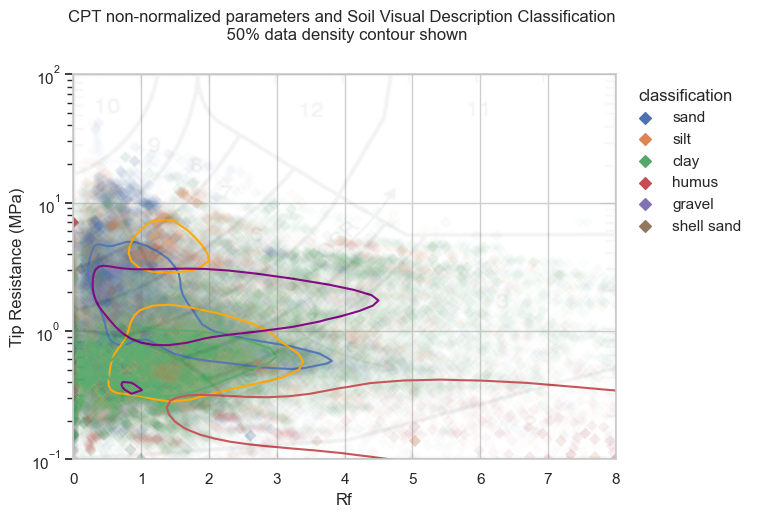

In [18]:
import warnings

warnings.filterwarnings('ignore')

clay_df = cpt_behaviour_df[cpt_behaviour_df["classification"]=="clay"]
silt_df = cpt_behaviour_df[cpt_behaviour_df["classification"]=="silt"]
sand_df = cpt_behaviour_df[cpt_behaviour_df["classification"]=="sand"]
gravel_df = cpt_behaviour_df[cpt_behaviour_df["classification"]=="gravel"]
humus_df = cpt_behaviour_df[cpt_behaviour_df["classification"]=="humus"]

percent_of_data_contours = [0.40]

im = plt.imread("static/SBT Robertson Non-Normalized Crop.png")


dfs = [sand_df,silt_df,clay_df,humus_df,gravel_df]
density_colours = ["Blues","Oranges","Greens","Reds","Purples"]
contour_colours = ["b","orange","g","r","purple"]

fig, ax = plt.subplots(figsize=(7,5))

for df, d_col, c_col in zip (dfs,density_colours,contour_colours):
    
    df.loc[:, ['Rf','cone_tip_resistance_uncorr']].pyroplot.density(
        ax = ax,
        bins=80,
        contours=percent_of_data_contours,
        colors=c_col,
        coverage_scale=1.5,
        logx = True,
        logy = True,
        label_contours=False
        )
sns.scatterplot(data=cpt_behaviour_df, x='Rf', y='cone_tip_resistance_uncorr', hue='classification', alpha = 0.02, ax = ax)

ax.set_yscale("log")
ax.set_ylim(0.1, 100)
ax.set_ylabel("Tip Resistance (MPa)")

ax.set_xlim(0, 8.0)
ax.set_title("CPT non-normalized parameters and Soil Visual Description Classification \n 50% data density contour shown")

ax_tw_x = ax.twinx()
ax_tw_x.axis('off')
ax2 = ax_tw_x.twiny()
ax2.set_zorder(2)

ax2.imshow(im, extent=[0,  8.0, 0.1, 100], aspect = "auto", alpha = 0.05)
ax2.axis('off')

plt.show()

## 2.2 Grain size


### 2.2.1 Load the grain size data extracted from downloaded grain size distribution curve PDF files (See 0.2.2.4)

In [8]:
grain_size_df = pd.read_csv("grain_size_df.csv")

Process the data to calculate D15, D50, D85, and percent fines

In [9]:
d15s = []
d50s = []
d85s = []
p_fines = []

d_lists = [d15s, d50s, d85s]
ds = [15,50,85]

cols = []
for col in grain_size_df.columns:
    try:
        _ = float(col)
        cols.append(col)
    except Exception:
        pass
float_cols = [float(col) for col in cols]

for row in list(grain_size_df[cols].iterrows()):
    list_vals = list(zip(row[1].values,float_cols))
    list_vals = sorted(filter(lambda x: not np.isnan(x[0]), list_vals), key=lambda x: x[0])
    y_interp = scipy.interpolate.interp1d(np.asarray(list_vals)[:,0], np.asarray(list_vals)[:,1])
    x_interp = scipy.interpolate.interp1d(np.asarray(list_vals)[:,1],np.asarray(list_vals)[:,0])



    for d_list, d in zip (d_lists,ds):
        try:
            d_list.append(round(float(y_interp(d)),3))
        except Exception:
            d_list.append(np.nan)

    try:
        p_fines.append(round(float(x_interp(0.075)),3))
    except Exception:
        p_fines.append(np.nan)

grain_size_df["D15"] = d15s
grain_size_df["D50"] = d50s
grain_size_df["D85"] = d85s
grain_size_df["Percent Fines"] = p_fines

grain_size_df["depths"] = grain_size_df["depths"].str.split("-")
grain_size_df["start_depth"] = [float(x[0]) if isinstance(x, list) else np.nan for x in grain_size_df["depths"]]
grain_size_df["end_depth"] = [float(x[1]) if isinstance(x, list) else np.nan for x in grain_size_df["depths"]]


### 2.2.2 CPT Correlation

#### Find CPT Data where grain size data exists. 

In [10]:
cpt_grain_df = pd.DataFrame()
count = 0
num_groups = len(grain_size_df.groupby(['prosjekt_id', 'investigation_point']))
for name, group in list(grain_size_df.groupby(['prosjekt_id', 'investigation_point'])):
    proj_df = cpt_df[cpt_df["prosjekt_id"] == name[0]]
    hole_df = proj_df[proj_df["investigation_point"] == name[1]]
    if not hole_df["file"].empty:
        data = libsgfdata.SGFData(join(hole_df["file"].values[0]), normalize=True)
        df = data.data #TODO COMPUTE NORMALIZED CPT FEATURES. compute_haugen_features(data.data, interval = interv)
        for i, result in group.iterrows():
            filtered = df[df["depth"]>result["start_depth"]]
            filtered = filtered[filtered["depth"]<result["end_depth"]]
            if filtered.size > 0:
                new_df = filtered #TODO: GET NORMALIZED QTN and FR new_df = filtered[["smooth_normmalized_pen","std_feed_thrust_force"]]
                new_df.loc[:, "D15 (mm)"] = result["D15"]
                new_df.loc[:, "D50 (mm)"] = result["D50"]
                new_df.loc[:, "D85 (mm)"] = result["D85"]
                new_df.loc[:, "Percent Fines"] = result["Percent Fines"]
                new_df.loc[:,"prosjekt_id"] = name[0]
                # new_df = new_df.dropna(axis=0)
                cpt_grain_df = pd.concat([cpt_grain_df,new_df])
                # print(count,"/", num_groups, "success")

    count += 1
num_samples = cpt_grain_df[['investigation_point', 'Percent Fines','prosjekt_id']].dropna(subset='Percent Fines').drop_duplicates().shape[0]
total_meters = cpt_grain_df[['investigation_point', 'Percent Fines','prosjekt_id']].dropna(subset='Percent Fines').shape[0]*(0.02)
print(f"Found {num_samples} total grain size distributions representative of {total_meters} m of CPT data")

Found 256 total grain size distributions representative of 183.1 m of CPT data


#### Calculate friction ratio 

In [11]:
cpt_grain_df["Rf"] = ((cpt_grain_df["friction_uncorr"]/1000)/cpt_grain_df["cone_tip_resistance_uncorr"])*100

#### Plot the grain size features over Robertson et al (1986) SBT chart using non-normalized CPT results 

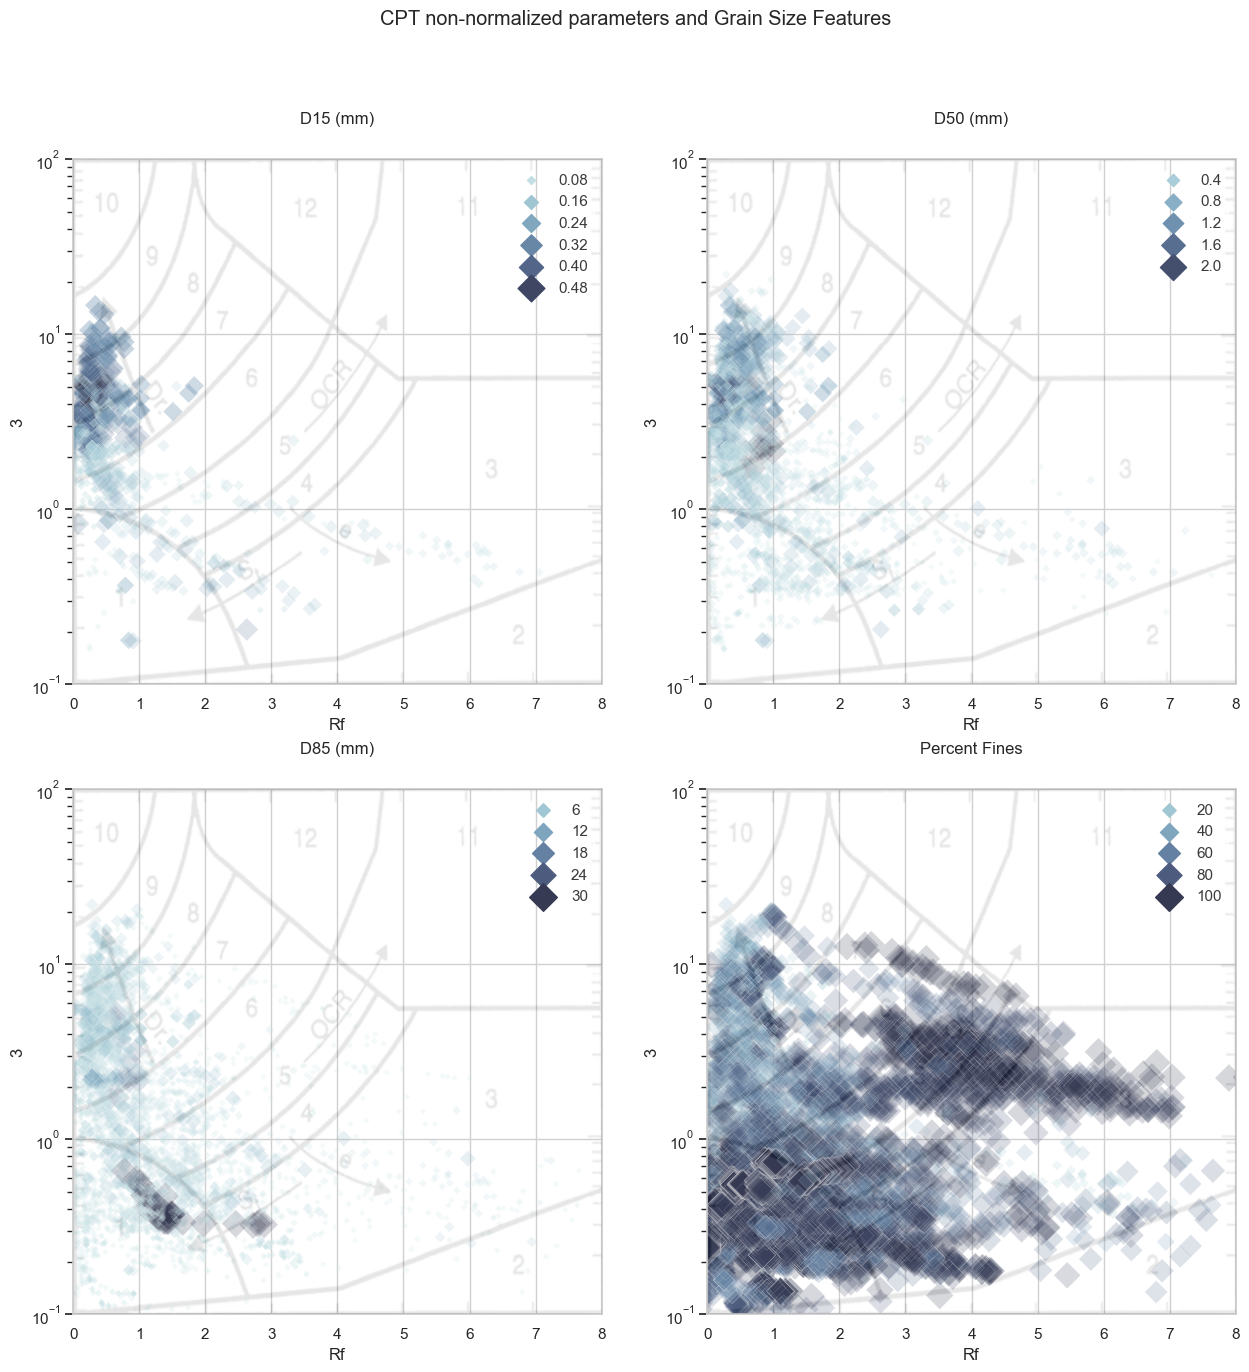

In [16]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

f, axs = plt.subplots(2,2,figsize=(15, 15))
f.suptitle('CPT non-normalized parameters and Grain Size Features', fontsize='large')

axs = axs.flatten()


for ax in axs.reshape(-1): 
  ax.set_ylabel(str(i))


im = plt.imread("static/SBT Robertson Non-Normalized Crop.png")

metrics = ["D15 (mm)","D50 (mm)","D85 (mm)","Percent Fines"]
for i, metric in enumerate(metrics):
    axs[i].set(yscale="log")
    axs[i].set_xlim(0, 8.0)
    axs[i].set_ylim(0.1, 100)
    # axs[i].set_zorder(2)



    sns.scatterplot(
        data=cpt_grain_df,
        x="Rf", y="cone_tip_resistance_uncorr",
        hue=metric, size=metric,
        palette=cmap, sizes=(10, 200), alpha = 0.2, ax = axs[i]
        
    )

    axs[i].legend(loc='upper right')
    axs[i].set_title(metric)

    ax_tw_x = axs[i].twinx()
    ax_tw_x.axis('off')
    ax2 = ax_tw_x.twiny()
    ax2.set_zorder(2)

    ax2.imshow(im, extent=[0,  8.0, 0.1, 100], aspect = "auto", alpha = 0.1)
    ax2.axis('off')

plt.show()
